all vocabularies sorted from more frequent to less frequent:
 ['9' '3' 'o' '6' 'a' '1' 'i' 'g' 's' '4' 'l' 'k' '8' 'u' '2' 'd' '5' 'y'
 'f' 'e' 'h' 'p' 'q' '0' 'j' '7' 't' 'r' 'w' 'n']
5 example pairs:
 [[16 14 12  3  9]
 [14  9  3 14 12]
 [ 9 12 14  1  3]
 [12  3  1  3 14]
 [ 3 14  3  9  1]]
step: 0, loss: 11.279191017150879
step: 200, loss: 4.082326889038086
step: 400, loss: 2.572678327560425
step: 600, loss: 2.095402240753174
step: 800, loss: 2.69031023979187
step: 1000, loss: 2.2478318214416504
step: 1200, loss: 1.8888330459594727
step: 1400, loss: 2.1021671295166016
step: 1600, loss: 1.5652540922164917
step: 1800, loss: 2.2648770809173584
step: 2000, loss: 1.9040746688842773
step: 2200, loss: 2.0212979316711426
step: 2400, loss: 1.950852394104004


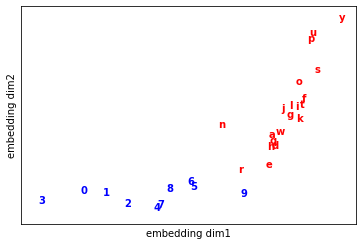

In [1]:
# [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/pdf/1301.3781.pdf)
from tensorflow import keras
import tensorflow as tf
from utils import process_w2v_data  
from visual import show_w2v_word_embedding 

tf.compat.v1.reset_default_graph()

corpus = [
    # numbers
    "5 2 4 8 6 2 3 6 4",
    "4 8 5 6 9 5 5 6",
    "1 1 5 2 3 3 8",
    "3 6 9 6 8 7 4 6 3",
    "8 9 9 6 1 4 3 4",
    "1 0 2 0 2 1 3 3 3 3 3",
    "9 3 3 0 1 4 7 8",
    "9 9 8 5 6 7 1 2 3 0 1 0",

    # alphabets, expecting that 9 is close to letters
    "a t g q e h 9 u f",
    "e q y u o i p s",
    "q o 9 p l k j o k k o p",
    "h g y i u t t a e q",
    "i k d q r e 9 e a d",
    "o p d g 9 s a f g a",
    "i u y g h k l a s w",
    "o l u y a o g f s",
    "o p i u y g d a s j d l",
    "u k i l o 9 l j s",
    "y g i s h k j l f r f",
    "i o h n 9 9 d 9 f a 9",
]


class CBOW(keras.Model):
    def __init__(self, v_dim, emb_dim):
        super().__init__()
        self.v_dim = v_dim
        self.embeddings = keras.layers.Embedding(
            input_dim=v_dim, output_dim=emb_dim,  # [n_vocab, emb_dim]
            embeddings_initializer=keras.initializers.RandomNormal(0., 0.1),
        )

        # noise-contrastive estimation
        self.nce_w = self.add_weight(
            name="nce_w", shape=[v_dim, emb_dim],
            initializer=keras.initializers.TruncatedNormal(0., 0.1))  # [n_vocab, emb_dim]
        self.nce_b = self.add_weight(
            name="nce_b", shape=(v_dim,),
            initializer=keras.initializers.Constant(0.1))  # [n_vocab, ]

        self.opt = keras.optimizers.Adam(0.01)

    def call(self, x, training=None, mask=None):
        # x.shape = [n, skip_window*2]
        o = self.embeddings(x)          # [n, skip_window*2, emb_dim]
        o = tf.reduce_mean(o, axis=1)   # [n, emb_dim]
        return o

    # negative sampling: take one positive label and num_sampled negative labels to compute the loss
    # in order to reduce the computation of full softmax
    def loss(self, x, y, training=None):
        embedded = self.call(x, training)
        return tf.reduce_mean(
            tf.nn.nce_loss(
                weights=self.nce_w, biases=self.nce_b, labels=tf.expand_dims(y, axis=1),
                inputs=embedded, num_sampled=5, num_classes=self.v_dim))

    def step(self, x, y):
        with tf.GradientTape() as tape:
            loss = self.loss(x, y, True)
            grads = tape.gradient(loss, self.trainable_variables)
        self.opt.apply_gradients(zip(grads, self.trainable_variables))
        return loss.numpy()


def train(model, data):
    for t in range(2500):
        bx, by = data.sample(8)
        loss = model.step(bx, by)
        if t % 200 == 0:
            print("step: {}, loss: {}".format(t, loss))


if __name__ == "__main__":
    d = process_w2v_data(corpus, skip_window=2, method="cbow")
    m = CBOW(d.num_word, 2)
    train(m, d)

    # plotting
    show_w2v_word_embedding(m, d, "./visual/results/cbow.png")